In [1]:
# need to writing a qiskit transpiler routing pass 
# not exactly sure yet how I will implement the qubit relabeling 
# https://qiskit.org/documentation/stubs/qiskit.transpiler.passes.SetLayout.html#qiskit.transpiler.passes.SetLayout

# this is an initialization analysis pass, idk what would happen if I try to call this again in the middle of the transpiler

# looks like all we have to do is modify self.property_set["layout"] attribute of the pass manager


In [2]:
from qiskit import QuantumCircuit

In [3]:
# define some dummy CX circuit to test the pass
# this is a 4 qubit circuit
qc = QuantumCircuit(4)
qc.cx(0,1)
qc.cx(1,2)
qc.cx(2,3)
qc.cx(3,0)
qc.cx(0,1)

qc.draw()

┌───┐     
q_0: ──■────────────┤ X ├──■──
     ┌─┴─┐          └─┬─┘┌─┴─┐
q_1: ┤ X ├──■─────────┼──┤ X ├
     └───┘┌─┴─┐       │  └───┘
q_2: ─────┤ X ├──■────┼───────
          └───┘┌─┴─┐  │       
q_3: ──────────┤ X ├──■───────
               └───┘

In [4]:
# first let's just create a line topology
from qiskit.transpiler import CouplingMap

backend = CouplingMap().from_line(4)
backend.draw()

ImportError: Pillow is necessary to use graphviz_draw() it can be installed with 'pip install pydot pillow'

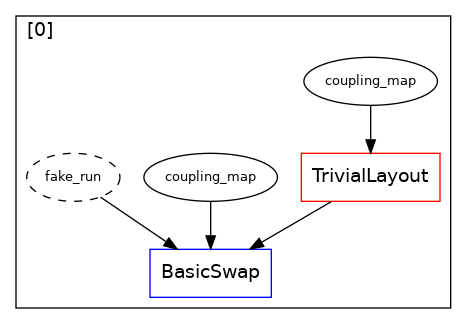

In [ ]:
# next, let's create a pass manager
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import SetLayout, TrivialLayout
from qiskit.transpiler.passes import BasicSwap

pm = PassManager()
pm.append([TrivialLayout(backend),  BasicSwap(backend)])
pm.draw()

In [ ]:
# now let's run the pass manager on our circuit
transp = pm.run(qc)
transp.draw()

┌───┐        
q_0 -> 0 ──■──────────────────┤ X ├─X──────
         ┌─┴─┐                └─┬─┘ │      
q_1 -> 1 ┤ X ├──■───────────X───■───X───■──
         └───┘┌─┴─┐         │         ┌─┴─┐
q_2 -> 2 ─────┤ X ├──■───X──X─────────┤ X ├
              └───┘┌─┴─┐ │            └───┘
q_3 -> 3 ──────────┤ X ├─X─────────────────
                   └───┘

In [ ]:
# compare to optimization level 3
from qiskit.compiler import transpile
transp = transpile(qc, optimization_level=3,coupling_map=backend)
transp.draw()

┌───┐
q_0 -> 0 ──■─────────X──────────┤ X ├
         ┌─┴─┐       │     ┌───┐└─┬─┘
q_1 -> 1 ┤ X ├──■────X─────┤ X ├──■──
         └───┘┌─┴─┐        └─┬─┘     
q_2 -> 2 ─────┤ X ├──■───X───■───────
              └───┘┌─┴─┐ │           
q_3 -> 3 ──────────┤ X ├─X───────────
                   └───┘

In [ ]:
# define a new equivalence library
import numpy as np
from qiskit.circuit import EquivalenceLibrary
eq = EquivalenceLibrary()

# CNS: CX = iSWAP + SWAP
qc = QuantumCircuit(2)
qc.rz(-np.pi/2, 0)
qc.h(1)
qc.rz(-np.pi/2, 1)
qc.iswap(0, 1)
qc.h(0)
qc.swap(0,1)
# qc.draw()

eq.add_equivalence(qc.to_instruction(), 'cx')

AttributeError: 'str' object has no attribute 'num_qubits'

In [ ]:
# start with can we get a benefit from existing algorithms

# how significant is the benefit? 
# need to look at restricted topologies